In [17]:
# Standard imports
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.pyplot as mpl
import matplotlib.cm as cm
import pandas as pd
import os
from scipy import interpolate as interp
from drama import utils
from scipy.stats import expon, rayleigh
mpl.rcParams['font.size'] = 12

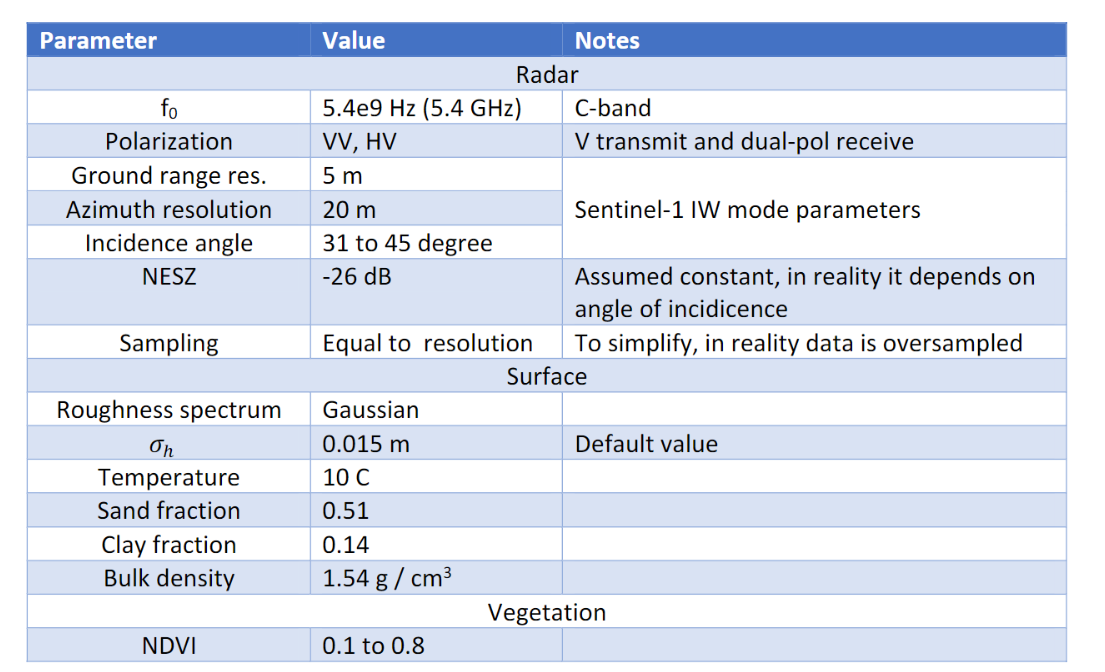

Considering bare soil (no canopy) adjust the autocorrelation length (l) of the roughness 
spectrum in order to have 𝜎_vv= -10 dB (0.1 in linear units) for an angle of incidence of 
40o, and a volumetric moisture fraction 𝑚%=0.2. To illustrate the impact of l make a 
plot showing how the NRCS depends on the it L-, C- and X-band. Discuss the results

In [2]:
theta_i = 40
sigma_h =0.015
T = 10
mv = 0.2
C_band = 5.4e9 

In [3]:
def GaussianSpectrum(kx, ky, sigma_h, l):
    # Do something... ideally your code works with both single values or with vectors or arrays
    # Here some dummy wrong code just to make an example plot
    k = kx**2 + ky**2
    S = (sigma_h**2)*((l**2)/np.pi)*np.exp(-(((k)*(l**2))/4))
    return S  


def ExponentialSpectrum(kx, ky, sigma_h, l):
    # Do something... ideally your code works with both single values or with vectors or arrays
    # Here some dummy wrong code just to make an example plot
    S = ((sigma_h**2)*2*(l**2))/(np.pi*((1+(kx**2 + ky**2)*l*l)**(3/2)))
    return S  

def NRCS_SMP(f, theta_i, epsilon_r, spec_f, sigma_h, l):
    # You can pass a function as an argument to a function, so that you can call it
    # it from within another function
    # Here you would calculate k_B (equation 6.14)
    c = 2.99792458e8
    k0 =2*np.pi*f/c
    k_B = 2*k0*np.sin(theta_i*np.pi/180)
    S = spec_f(k_B, 0, sigma_h, l)
    # rest of your code
    alpha_hh = np.abs((epsilon_r-1)/((np.cos(theta_i) + np.sqrt(epsilon_r-np.sin(theta_i*np.pi/180)))**2))
    alpha_vv = np.abs(((epsilon_r-1)*((epsilon_r-1)*np.sin(theta_i*np.pi/180) + epsilon_r))/(((epsilon_r*np.cos(theta_i*np.pi/180))+np.sqrt(epsilon_r-np.sin(theta_i*np.pi/180)**2))**2))
    
    NRCS_hh = 4*np.pi*(k0**4)*(np.cos(np.radians(theta_i))**4)*(alpha_hh**2)*S
    NRCS_vv = 4*np.pi*(k0**4)*(np.cos(np.radians(theta_i))**4)*(alpha_vv**2)*S
    
    return NRCS_hh, NRCS_vv

YOU CAN HELP BY FIGURING OUT THE COMPUTATION FOR EPSILON

In [4]:
theta_i = 40
sigma_h =0.015
T = 10
mv = 0.2
C_band = 5.4e9 
epsilon_r = 80 # I NEED TO FIND OUT WHAT EPSILON TO USE

Here we adjust autocorrelation lenght to match NRCS= 0.1 --> two answers?

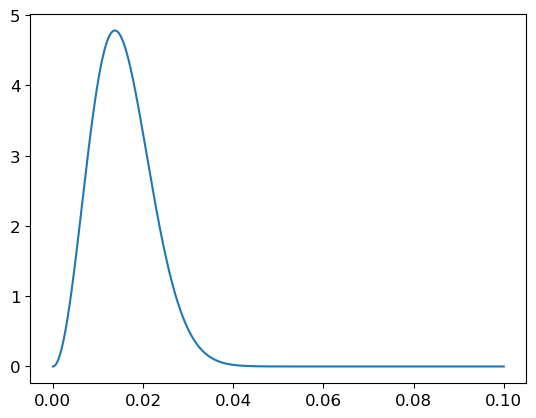

In [5]:
ls = np.linspace(0,0.1, 1000)

c_NRCS_hh_g, c_NRCS_vv_g = NRCS_SMP(C_band, theta_i, epsilon_r, GaussianSpectrum, sigma_h, ls)

plt.plot(ls, c_NRCS_hh_g)


## Part 2

2.With the adjusted l, make a figure showing the VV NRCS for a bare soil as a function of 
incidedence angle for angles of incidence of 320 and 40o.  


Text(0.5, 0, 'Angle, degrees')

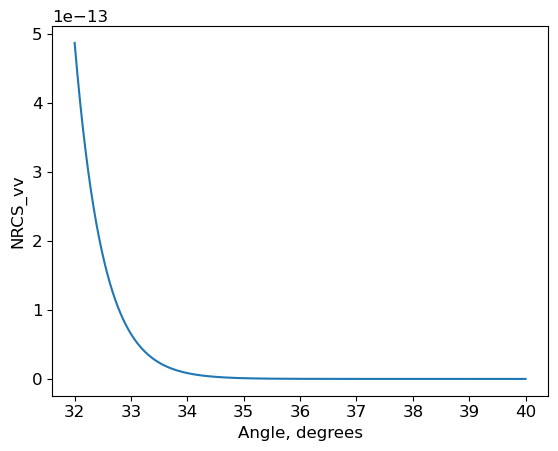

In [6]:
# ADJUSTMENT OF DIELECTRIC CONSTANT???
# epsilon_r = ?

l_adjusted = 0.1 # THIS NEEDS TO CHANGE
angles = np.linspace(32,40,1000)

c_NRCS_hh_g, c_NRCS_vv_g = NRCS_SMP(C_band, angles, epsilon_r, GaussianSpectrum, sigma_h, l_adjusted)

plt.plot(angles, c_NRCS_vv_g)
plt.ylabel('NRCS_vv')
plt.xlabel('Angle, degrees') #CHANGE THIS TO LATEX NOTATION




## Part 3

Adding the WCM model, i.e. combining the canopy model in Baghadi et.al. with our 
surface scattering component, make your own version of Figure 5 in the paper, i.e. 
compute the NRCS for VH and VV polarization as a function of NDVI for angles of 
incidence of 32 and 40 degrees. Repeat this for values of 𝑚% of 0.1 and 0.25. Discuss the results 
addressing: 
a. How de sensitivity of the total  NRCS to soil moisture depends on the NDVI. 
b. How the different contributions to the NRCS depend on the angle of incidence.

## Part 4

In [7]:
def moving_average(data, Naz, Nrg, downsample=False):
    """ A moving average filter for you
    Args:
        data: 2D numpy array
        Naz: number of samples averaged in azimuth (first dimension)
        Nrg: number of samples averaged in range (second dimension)
        downsample: True if you want to downsample after averaging
    """
    filt_data = utils.smooth(utils.smooth(data, Nrg, axis=1), Naz, axis=0)
    if downsample:
        filt_data = filt_data[int(Naz/2)::Naz, int(Nrg/2)::Nrg]
    return filt_data

def chessboard_nrcs(shape, nrcs_black=0.01, nrcs_white=0.1, square_size=100, daz=20, dgr=5):
    """ Creates a chessboard pattern
    
    Args:
        shape: shape of output matrix
        nrcs_black (float):  nrcs for black squares. User decides if these are db or linear values.
        nrcs_white (float): nrcs for white squares...
        square_size (float): size of each square, in meters. Defaults to 100.
        daz (float): azimuth resolution (or in this case sampling). Defaults to 20 m.
        dgr (float): ground range resolution (sampling). Defaults to 5 m.
        
    """
    # This can be done in many ways, so do not put too much value in this particular implementation.
    aind = np.arange(shape[0]).reshape((shape[0], 1))
    rind = np.arange(shape[1]).reshape((1, shape[1]))
    apat = np.int32(aind*daz/square_size)
    rpat = np.int32(rind*dgr/square_size)
    chess_board = np.mod(apat + rpat, 2)
    chess_board = chess_board * (nrcs_white - nrcs_black) + nrcs_black
    return chess_board

Now we will model speckle. To do that we will simulate a radar image with a chess-board 
pattern. Let us assume a small area, for example 1x1 km2 (how many pixels do you have in 
range and in azimuth), with the scene characteristics constant in squares of 100x100 m2. You 
can assume that the observation geometry (angle of incidence) is constant over the 1x1 km2 
area. Each pixel can be modeled by the product of a circular Gaussian complex random variable. 
For example, the following lines 

nrcs = 0.1 

slc = np.sqrt(nrcs/2) * (np.random.randn(50,200) + 1j*np.random.randn(50,200))

4. Taking constant parameters for the entire scene compute and represent the histogram 
of the amplitude (|slc|) and of the intensity (|slc|&). Check that the histograms 
correspond to a Rayleigh and exponential distribution, respectively. Calculate the mean 
value and the standard deviation in both cases.

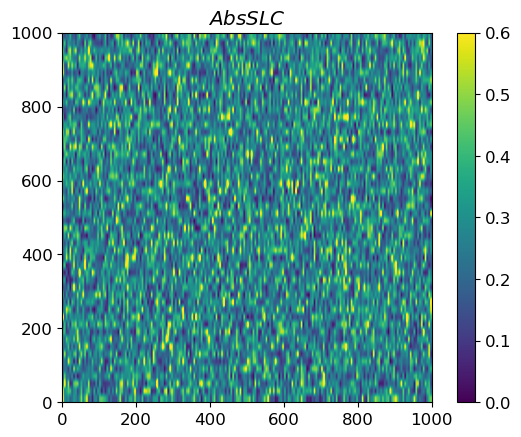

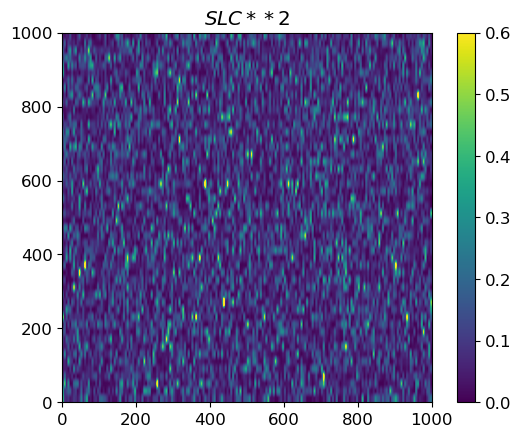

In [44]:

nrange = int(1000/5)
nazimuth = int(1000/20)

# Computing uniform Checkerboard (no pattern)
cbrd_nrcs = chessboard_nrcs((nazimuth, nrange), 0.1, 0.1, square_size=100)

# Adding noise 
slc  = np.sqrt(cbrd_nrcs/2) * (np.random.randn(50,200) + 1j*np.random.randn(50,200))
slc_power =slc**2

plt.figure()
plt.title("$Abs{SLC}$")
plt.imshow(abs(slc), origin='lower', extent=(0,1000,0,1000), vmin=0, vmax=0.6)
plt.colorbar()
plt.show()

plt.figure()
plt.title("$SLC**2$")
plt.imshow(abs(slc_power), origin='lower', extent=(0,1000,0,1000),vmin=0, vmax=0.6)
plt.colorbar()
plt.show()



In [40]:
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

## Histograms and checking distritbutions

Exponential Distribution: Mean = 0.1013, Std Dev = 0.1013
Rayleigh Distribution: Mean = 0.2783, Std Dev = 0.1455


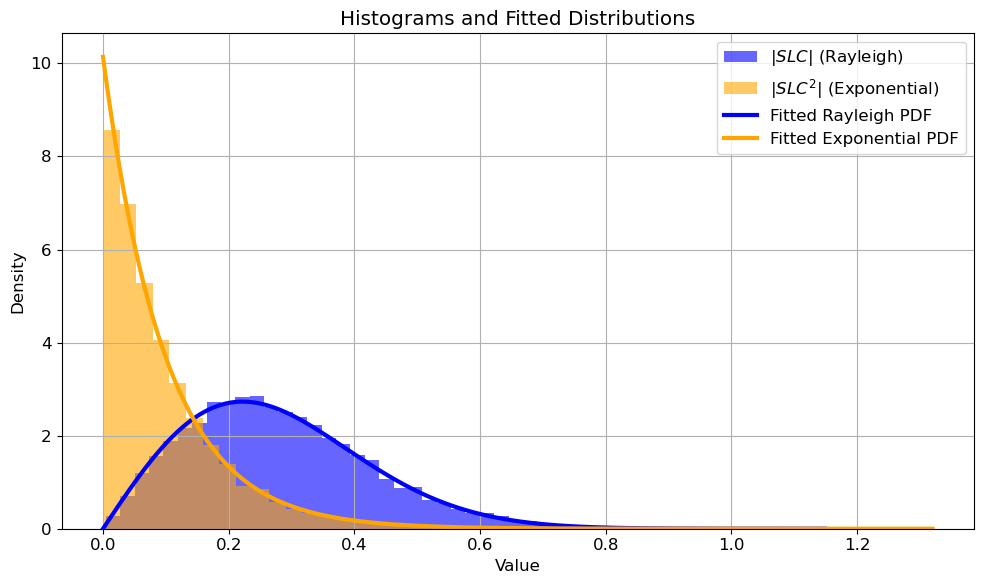

In [49]:
abs_slc = abs(slc).flatten()  #Rayleigh one
abs_slc_power= abs(slc_power).flatten()  #Exponential one

# Fitting distributions and calculating mean and standard deviation
exp_params = expon.fit(abs_slc_power, floc=0)  
exp_scale = exp_params[1] 

rayleigh_params = rayleigh.fit(abs_slc, floc=0)  
rayleigh_scale = rayleigh_params[1]  

rayleigh_mean = rayleigh_scale * np.sqrt(np.pi / 2)
rayleigh_std = rayleigh_scale * np.sqrt((4 - np.pi) / 2)

print(f"Exponential Distribution: Mean = {exp_mean:.4f}, Std Dev = {exp_std:.4f}")
print(f"Rayleigh Distribution: Mean = {rayleigh_mean:.4f}, Std Dev = {rayleigh_std:.4f}")


#Computing fitted distributions
x1 = np.linspace(0, np.max(abs_slc), 1000)  
x2 = np.linspace(0, np.max(abs_slc_power), 1000) 

rayleigh_pdf = rayleigh.pdf(x1, scale=rayleigh_scale)
exp_pdf = expon.pdf(x2, scale=exp_scale)

#Plotting
plt.figure(figsize=(10, 6))
plt.hist(abs_slc.flatten(), bins=50, density=True, color='blue', alpha=0.6, label='$|SLC|$ (Rayleigh)')
plt.hist(abs_slc_power.flatten(), bins=50, density=True, color='orange', alpha=0.6, label='$|SLC^2|$ (Exponential)')

plt.plot(x1, rayleigh_pdf, 'blue', lw=3, label='Fitted Rayleigh PDF')
plt.plot(x2, exp_pdf, 'orange', lw=3, label='Fitted Exponential PDF')

plt.xlabel('Value')
plt.ylabel('Density')
plt.title('Histograms and Fitted Distributions')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## Part 5

5. Generate multilooked products for 4 looks (a 20x20 m2) 16 looks (40x40 m2) and  100 
looks (100x100 m2) and compute the corresponding intensity of histograms and 
corresponding means and standard deviations. At what point do the histograms look 
like a Gaussian distribution?a

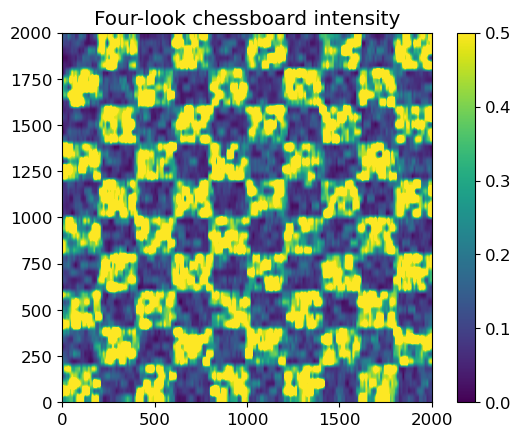

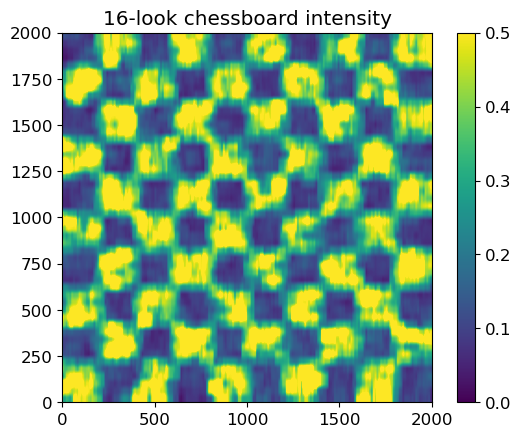

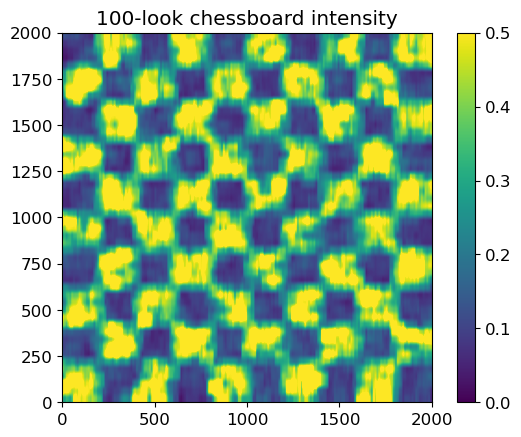

In [68]:
# We can do some multilooking
cbrd_int_4looks = moving_average(abs(slc_power), 1, 4, downsample=False)
plt.figure()
plt.imshow(cbrd_int_4looks, origin='lower', extent=(0,2000,0,2000), vmin=0, vmax=0.5)
plt.title("Four-look chessboard intensity")
plt.colorbar()

#16-Looks
cbrd_int_16looks = moving_average(abs(slc_power), 2, 8, downsample=False)
plt.figure()
plt.imshow(cbrd_int_16looks, origin='lower', extent=(0,2000,0,2000), vmin=0, vmax=0.5)
plt.title("16-look chessboard intensity")
plt.colorbar()

#100 Looks
cbrd_int_100looks = moving_average(abs(slc_power), 5, 20, downsample=False)
plt.figure()
plt.imshow(cbrd_int_16looks, origin='lower', extent=(0,2000,0,2000), vmin=0, vmax=0.5)
plt.title("100-look chessboard intensity")
plt.colorbar()

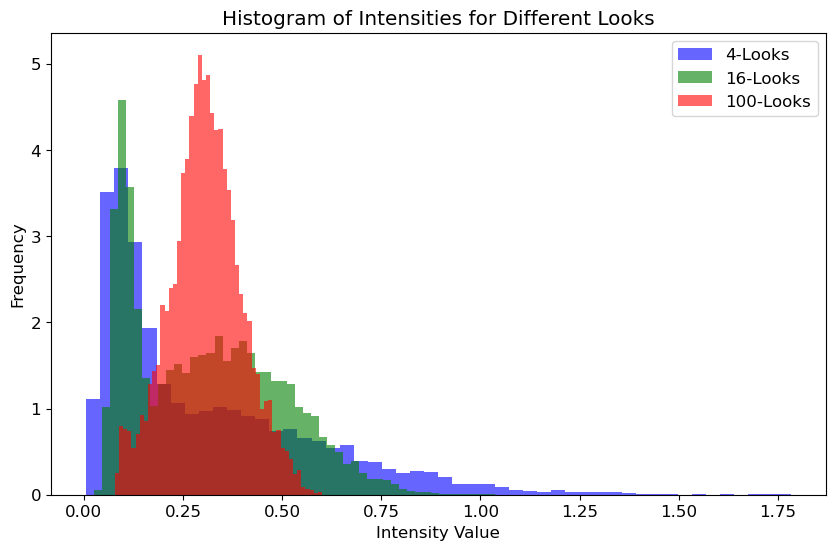

In [69]:
cbrd_int_4looks_flat = cbrd_int_4looks.flatten()
cbrd_int_16looks_flat = cbrd_int_16looks.flatten()
cbrd_int_100looks_flat = cbrd_int_100looks.flatten()

# Create the histogram plot
plt.figure(figsize=(10, 6))

# Plot histograms for each array
plt.hist(cbrd_int_4looks_flat, bins=50, alpha=0.6, label="4-Looks", color='blue', density=True)
plt.hist(cbrd_int_16looks_flat, bins=50, alpha=0.6, label="16-Looks", color='green', density=True)
plt.hist(cbrd_int_100looks_flat, bins=50, alpha=0.6, label="100-Looks", color='red', density=True)

# Add labels and title
plt.xlabel("Intensity Value")
plt.ylabel("Frequency")
plt.title("Histogram of Intensities for Different Looks")
plt.legend()

# Show the plot
plt.show()


The intensity distribution looks gaussian when applying the 100 look. The original single look is exponential

## Part 6

Generate a checkboard pattern where the “white” squares have an NDVI of 0.5 (for 
example) and the “black” squares correspond to bare soil. Represent the resulting 
intensity, in dB, with and without multilooking (use the 16 looks option). Do this both 
for VV and HH polarization. You may need to adjust the dynamic range of the figure 
(because log'"0=−∞).

In [ ]:
# Convert to dB scale
db_values = 10 * np.log10(linear_values)

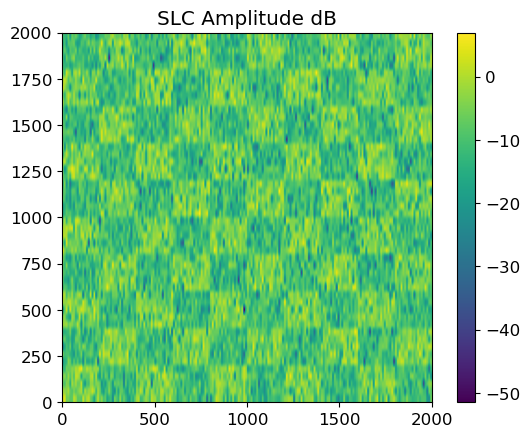

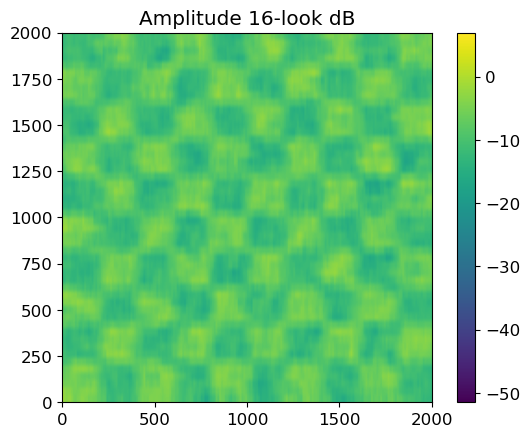

In [70]:

bare_nrcs = 0.1 #CHANGE THIS FOR DIELECTRIC CONSTANT NEED VV AND HH POLARIZATION
vegetated_nrcs =0.5 #CHANGE THIS USING VEGETATION MODEL

cbrd_nrcs = chessboard_nrcs((nazimuth, nrange), vegetated_nrcs, bare_nrcs, square_size=100)

slc  = np.sqrt(cbrd_nrcs/2) * (np.random.randn(50,200) + 1j*np.random.randn(50,200)) #DO WE INCLUDE NOISE OR NOT
slc_power =slc**2

slc_db = 10 * np.log10(abs(slc))
slc_power_db  = 10 * np.log10(abs(slc_power))


plt.figure()
plt.title('SLC Amplitude dB')
plt.imshow(slc_power_db, origin='lower', extent=(0,2000,0,2000))
plt.colorbar()
plt.show()


cbrd_int_16looks = moving_average(slc_power_db, 2, 8, downsample=False)

plt.figure()
plt.title('Amplitude 16-look dB')
plt.imshow(cbrd_int_16looks, origin='lower', extent=(0,2000,0,2000),  vmin=np.min(slc_power_db), vmax=np.max(slc_power_db))
plt.colorbar()
plt.show()



## Part 7

To round off the assignment we will add thermal noise. You can model noise in the same way as 
the “slc” variable, but with the intensity that corresponds to the NESZ. Once you have your 
noise realization you can add it to your SLC.

7. Redo the checkboard figures with the noise added and discuss what you see

 **this needs to be done for VV and HH for which I suppose we get different values for NRCS due to the dielectric constant change**

0.9418895965228413


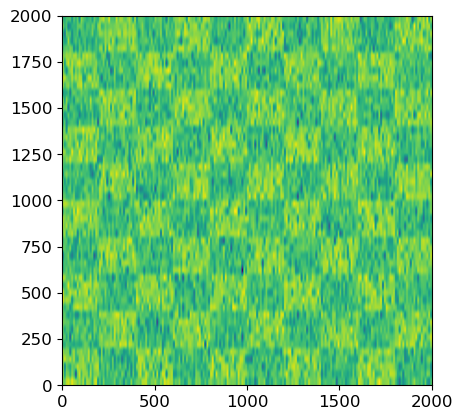

In [80]:
NESZ_db = -0.26  #IN dB!!

# Convert to linear
NESZ = 10 ** (NESZ_db / 10)

print(NESZ)
# # Computing uniform Checkerboard (no pattern)
cbrd_nrcs = chessboard_nrcs((nazimuth, nrange), vegetated_nrcs, bare_nrcs, square_size=100)

# # Adding noise 
slc  = np.sqrt(cbrd_nrcs/2) * (np.random.randn(50,200) + 1j*np.random.randn(50,200))

slc_power_db  = 10 * np.log10(abs(slc**2))

slc_nesz_power_db =slc_power_db  + NESZ
plt.imshow(slc_nesz_power_db, origin='lower', extent=(0,2000,0,2000))

# plt.hist(slc_nesz_power_db.flatten(), density=True, bins=50)


In [ ]:
# We can do some multilooking
cbrd_int_4looks = moving_average(abs(slc_power), 1, 4, downsample=False)
plt.figure()
plt.imshow(cbrd_int_4looks, origin='lower', extent=(0,2000,0,2000), vmin=0, vmax=0.5)
plt.title("Four-look chessboard intensity")
plt.colorbar()

#16-Looks
cbrd_int_16looks = moving_average(abs(slc_power), 2, 8, downsample=False)
plt.figure()
plt.imshow(cbrd_int_16looks, origin='lower', extent=(0,2000,0,2000), vmin=0, vmax=0.5)
plt.title("16-look chessboard intensity")
plt.colorbar()

#100 Looks
cbrd_int_100looks = moving_average(abs(slc_power), 5, 20, downsample=False)
plt.figure()
plt.imshow(cbrd_int_16looks, origin='lower', extent=(0,2000,0,2000), vmin=0, vmax=0.5)
plt.title("100-look chessboard intensity")
plt.colorbar()

cbrd_nrcs = chessboard_nrcs((nazimuth, nrange), 0.1, 0.1, square_size=100)


## PART 8

8. With our model, in the VH channel we only have the contribution of the vegetation 
(because for the small perturbation model, 𝜎",$(=0). Determine the NDVI value for 
which the SNR becomes 1. 

No clue about this